In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
from matplotlib import cm
import locale
locale.setlocale(locale.LC_TIME,'es_ES')

'es_ES'

# Data

**Datos Abiertos de la Dirección General de Epidemiología**:

https://www.gob.mx/salud/documentos/datos-abiertos-152127

In [2]:
# Datos
! rm ./data/datos_abiertos_covid19.zip
! wget -P ./data http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip

# Diccionario de datos
! rm ./data/diccionario_datos_covid19.zip
! wget -P ./data http://epidemiologia.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip
! unzip ./data/diccionario_datos_covid19.zip -d data

# Fecha de actualización
date = pd.to_datetime("today").strftime('%B %d, %Y')
print('\nLatest update is:',date)

--2020-09-02 15:58:00--  http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip
Resolving datosabiertos.salud.gob.mx... 187.210.186.146
Connecting to datosabiertos.salud.gob.mx|187.210.186.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28812370 (27M) [application/x-zip-compressed]
Saving to: './data/datos_abiertos_covid19.zip'

datos_abiertos_covi 100%[===================>]  27.48M  1.85MB/s    in 18s     

2020-09-02 15:58:18 (1.56 MB/s) - './data/datos_abiertos_covid19.zip' saved [28812370/28812370]

--2020-09-02 15:58:18--  http://epidemiologia.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip
Resolving epidemiologia.salud.gob.mx... 187.191.75.207
Connecting to epidemiologia.salud.gob.mx|187.191.75.207|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://epidemiologia.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip [following]
--2020-0

# Dataframes

In [4]:
# Datast principal
df = pd.read_csv('./data/datos_abiertos_covid19.zip', compression='zip', encoding='iso8859_15')

# Diccionarios
x1 = pd.ExcelFile('./data/diccionario_datos_covid19/Descriptores_0419.xlsx')
x2 = pd.ExcelFile('./data/diccionario_datos_covid19/Catalogos_0412.xlsx')

# Entidades
entidades = x2.parse('Catálogo de ENTIDADES')

# Población por entidad (del tablero Conacyt: https://coronavirus.gob.mx/datos/)
df_pob = pd.read_csv("./data/Casos_Diarios_Estado_Nacional_Confirmados_20200801.csv")
df_pob = df_pob[['cve_ent', 'poblacion']][:-1]

/Users/jnicolas/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data processing

In [5]:
# Filtro por tipo de paciente (Confirmado=1). Ver: x2.parse('Catálogo RESULTADO')
condition1 = df['RESULTADO'] == 1 
temp1 = df[condition1][['FECHA_SINTOMAS','ENTIDAD_RES']]

# Creación de la tabla principal
temp1['VALUES'] = 1
temp1 = temp1.groupby(['FECHA_SINTOMAS','ENTIDAD_RES']).sum().reset_index()
temp1 = temp1.pivot(index='FECHA_SINTOMAS', columns='ENTIDAD_RES', values='VALUES').T
temp2 = temp1.join(df_pob.set_index('cve_ent'), on='ENTIDAD_RES')
temp3 = temp2.join(entidades.set_index('CLAVE_ENTIDAD'),on='ENTIDAD_RES').reset_index()
temp3 = temp3.set_index(['ENTIDAD_RES','poblacion','ENTIDAD_FEDERATIVA','ABREVIATURA']).reset_index()
temp3 = temp3.set_index('ENTIDAD_RES').fillna(0)

df_data = temp3.replace({
                'VERACRUZ DE IGNACIO DE LA LLAVE':'VERACRUZ',
                'MICHOACÁN DE OCAMPO':'MICHOACÁN',
                'COAHUILA DE ZARAGOZA':'COAHUILA',
                'BAJA CALIFORNIA SUR':'BCS',
                'CIUDAD DE MÉXICO':'CDMX'})
df_data

,poblacion,ENTIDAD_FEDERATIVA,ABREVIATURA,2020-01-13,2020-01-29,2020-02-06,2020-02-19,2020-02-21,2020-02-22,2020-02-23,...,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31
ENTIDAD_RES,,,,,,,,,,,,,,,,,,,,,
1,1434635,AGUASCALIENTES,AS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,41.0,35.0,45.0,15.0,13.0,2.0,3.0,0.0,0.0
2,3634868,BAJA CALIFORNIA,BC,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,61.0,47.0,50.0,25.0,21.0,8.0,0.0,0.0,0.0,0.0
3,804708,BCS,BS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,112.0,93.0,95.0,84.0,23.0,13.0,36.0,18.0,0.0
4,1000617,CAMPECHE,CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,11.0,8.0,9.0,5.0,3.0,2.0,0.0,0.0,0.0
5,3218720,COAHUILA,CL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,152.0,162.0,183.0,135.0,86.0,36.0,26.0,9.0,1.0,5.0
6,785153,COLIMA,CM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,68.0,40.0,40.0,31.0,22.0,7.0,0.0,0.0,0.0,0.0
7,5730367,CHIAPAS,CS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,5.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0
8,3801487,CHIHUAHUA,CH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,11.0,14.0,10.0,4.0,3.0,0.0,0.0,0.0,0.0
9,9018645,CDMX,DF,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,457.0,374.0,499.0,364.0,278.0,193.0,50.0,14.0,0.0,0.0


In [6]:
# Casos totales
df_absolute = df_data.drop(['ABREVIATURA','poblacion'],axis=1).set_index('ENTIDAD_FEDERATIVA').T.cumsum()
df_absolute.index = pd.to_datetime(df_absolute.index,format="%Y-%m-%d")

# Casos relativos (por 100 mil hab)
df_relative = df_absolute/df_data.set_index('ENTIDAD_FEDERATIVA')['poblacion']*1e5
df_relative.index = pd.to_datetime(df_relative.index,format="%Y-%m-%d")

In [7]:
# Corte de los últimos 14 días a la fecha de descarga para casos netos
data_absolute = df_absolute.T.sort_index().T
pad_window = 14
if pad_window > 0: data_absolute = data_absolute.drop(data_absolute.index[-pad_window:],axis=0)
else: data_absolute = data_absolute
data_absolute

ENTIDAD_FEDERATIVA,AGUASCALIENTES,BAJA CALIFORNIA,BCS,CAMPECHE,CDMX,CHIAPAS,CHIHUAHUA,COAHUILA,COLIMA,DURANGO,...,QUINTANA ROO,SAN LUIS POTOSÍ,SINALOA,SONORA,TABASCO,TAMAULIPAS,TLAXCALA,VERACRUZ,YUCATÁN,ZACATECAS
2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-13,5055.0,16110.0,6527.0,5324.0,91218.0,6130.0,7509.0,19209.0,2997.0,5523.0,...,9508.0,16445.0,15277.0,20620.0,26781.0,23191.0,5985.0,26881.0,13028.0,4405.0
2020-08-14,5136.0,16207.0,6616.0,5350.0,91999.0,6149.0,7546.0,19486.0,3070.0,5612.0,...,9579.0,16656.0,15370.0,20740.0,26918.0,23373.0,6021.0,27079.0,13194.0,4478.0
2020-08-15,5212.0,16285.0,6700.0,5393.0,92857.0,6181.0,7604.0,19764.0,3142.0,5693.0,...,9655.0,16839.0,15498.0,20858.0,27129.0,23598.0,6078.0,27275.0,13323.0,4557.0
2020-08-16,5266.0,16382.0,6808.0,5416.0,93406.0,6196.0,7641.0,19967.0,3206.0,5751.0,...,9713.0,16990.0,15578.0,20953.0,27233.0,23749.0,6115.0,27423.0,13458.0,4626.0


In [8]:
# Corte de los últimos 14 días a la fecha de descarga para casos relativos
data_relative = df_relative.T.sort_index().T
pad_window = 14
if pad_window > 0: data_relative = data_relative.drop(data_relative.index[-pad_window:],axis=0)
else: data_relative = data_relative
data_relative

ENTIDAD_FEDERATIVA,AGUASCALIENTES,BAJA CALIFORNIA,BCS,CAMPECHE,CDMX,CHIAPAS,CHIHUAHUA,COAHUILA,COLIMA,DURANGO,...,QUINTANA ROO,SAN LUIS POTOSÍ,SINALOA,SONORA,TABASCO,TAMAULIPAS,TLAXCALA,VERACRUZ,YUCATÁN,ZACATECAS
2020-01-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-06,0.000000,0.027511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-19,0.000000,0.027511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-21,0.000000,0.027511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.031679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-13,352.354432,443.207291,811.101667,532.071712,1011.437971,106.973951,197.527967,596.790028,381.709043,295.506250,...,551.745269,573.767804,483.958749,670.624718,1041.135768,635.265088,433.692195,314.770894,576.690343,264.338170
2020-08-14,358.000467,445.875889,822.161579,534.670109,1020.097808,107.305518,198.501271,605.395934,391.006594,300.268165,...,555.865369,581.129616,486.904888,674.527481,1046.461767,640.250567,436.300870,317.089433,584.038408,268.718803
2020-08-15,363.297982,448.021771,832.600148,538.967457,1029.611433,107.863947,200.026989,614.032907,400.176781,304.602043,...,560.275617,587.514506,490.959789,678.365198,1054.664584,646.413934,440.431272,319.384552,589.748652,273.459488
2020-08-16,367.062005,450.690369,846.021165,541.266039,1035.698822,108.125710,201.000293,620.339762,408.328058,307.705313,...,563.641333,592.782912,493.494102,681.454885,1058.707679,650.550238,443.112410,321.117601,595.724488,277.600085


# Figures

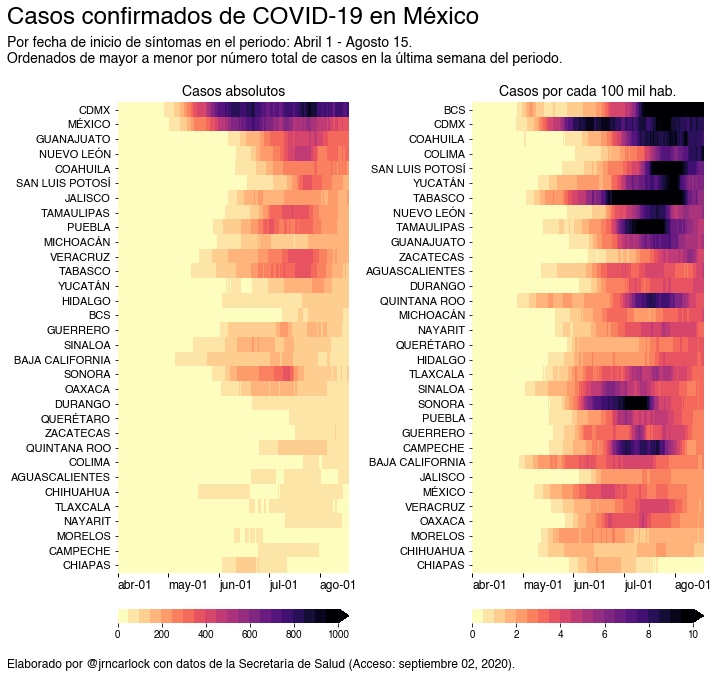

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,8))

for i in range(2):

    if i==0:
        my_data = data_absolute.copy()
        vmax = 1000
        dvis = 20
        title='Casos absolutos'
    if i==1:
        my_data = data_relative.copy()
        vmax = 10
        dvis = 20
        title='Casos por cada 100 mil hab.'
    
    last_week = (my_data - my_data.shift()).tail(7).mean()
    my_data = my_data.T
    
    my_data['last_week'] = last_week
    my_data = my_data.sort_values(by='last_week', ascending=False)
    my_data = my_data.T.drop('last_week')
    my_data.index = pd.to_datetime(my_data.index,format="%Y-%m-%d")
    
    my_data = my_data - my_data.shift(1)
    my_data.index = my_data.index.strftime("%b-%d").astype('str')
    my_data = my_data.rolling(window=7, min_periods=1, center=True).mean()
    my_data = my_data.T

    cmap= plt.cm.get_cmap('magma_r', dvis)
    vmin=0
    my_label=''

    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("bottom", size="3%", pad=0.5)

    sns.heatmap(my_data, ax=ax[i], cmap=cmap, linewidths=0.0,
                cbar_ax=cax, cbar_kws={"orientation":"horizontal", "extend":"max", 'label': my_label},
                vmin=vmin,vmax=vmax)

    ax[i].tick_params(axis='x',labelcolor='k', labelsize=12, width=1, labelbottom=True, labeltop=False)
    ax[i].tick_params(axis='y',labelsize=11)
    plt.setp(ax[i].get_xticklabels(), rotation=0, ha="left")
    ax[i].figure.axes[-1].yaxis.label.set_size(14)

    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].set_xticklabels(['abr-01',
                           'may-01',
                           'jun-01',
                           'jul-01',
                           'ago-01'])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(title, fontsize=14)
    
fig.suptitle('Casos confirmados de COVID-19 en México', 
             fontsize=24, weight= 'bold', ha='left', x=0.01, y= 1.117)

fig.text(0.01,1.02, 
         "Por fecha de inicio de síntomas en el periodo: Abril 1 - Agosto 15.\n" +
         "Ordenados de mayor a menor por número total de casos en la última semana del periodo.", 
         fontsize=14, ha='left', color='k')

my_legend = "Elaborado por @jrncarlock con datos de la Secretaría de Salud (Acceso: "+ date +")."
fig.text(0.01,-0.03, my_legend, fontsize=12, ha='left', color='k')

plt.tight_layout()

In [12]:
fig.savefig('./images/estados_mapa.png',dpi=600,bbox_inches='tight')

In [13]:
def codify(my_data):
    estados = pd.DataFrame()
    estados['names'] = my_data
    estados['codes'] = estados['names'].replace({
     'TABASCO':'TAB',
     'BCS':'BCS',
     'SAN LUIS POTOSÍ':'SLP',
     'CDMX':'CMX',
     'TAMAULIPAS':'TAM',
     'CAMPECHE':'CAM',
     'COAHUILA':'COA',
     'YUCATÁN':'YUC',
     'QUINTANA ROO':'ROO',
     'NUEVO LEÓN':'NLE',
     'GUANAJUATO':'GUA',
     'COLIMA':'COL',
     'TLAXCALA':'TLA',
     'PUEBLA':'PUE',
     'NAYARIT':'NAY',
     'AGUASCALIENTES':'AGU',
     'SONORA':'SON',
     'ZACATECAS':'ZAC',
     'VERACRUZ':'VER',
     'GUERRERO':'GRO',
     'DURANGO':'DUR',
     'SINALOA':'SIN',
     'HIDALGO':'HID',
     'OAXACA':'OAX',
     'BAJA CALIFORNIA':'BCN',
     'MÉXICO':'MEX',
     'JALISCO':'JAL',
     'MICHOACÁN':'MIC',
     'QUERÉTARO':'QUE',
     'MORELOS':'MOR',
     'CHIHUAHUA':'CHH',
     'CHIAPAS':'CHP'})
    return estados

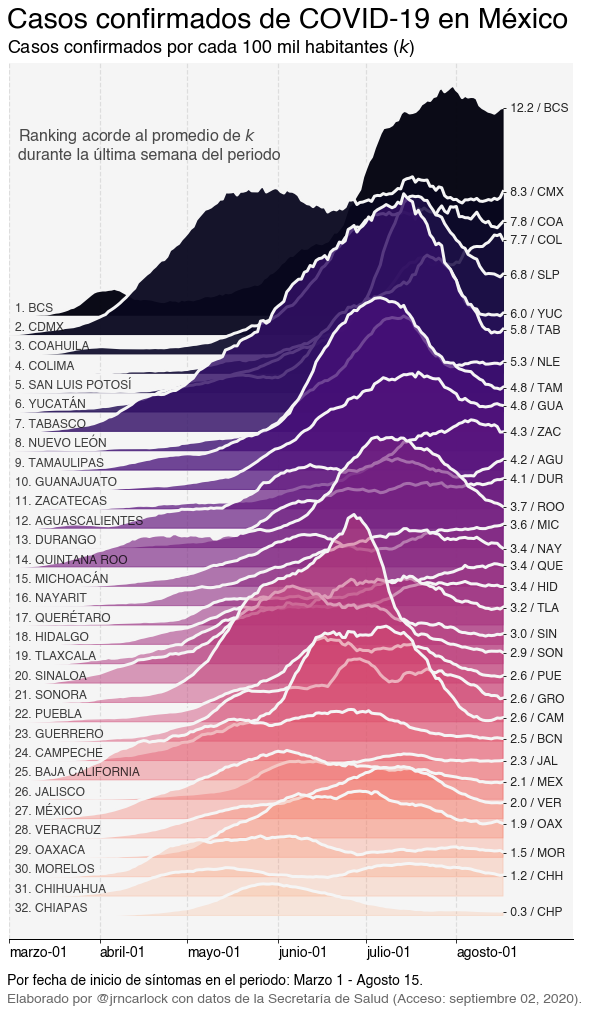

In [23]:
fig, ax = plt.subplots(figsize=(8.25,12.75))

my_data = data_relative.copy()
last_week = (my_data - my_data.shift()).tail(7).mean()
my_data = my_data.T

my_data['last_week'] = last_week
my_data = my_data.sort_values(by='last_week', ascending=False)
my_data = my_data.T.drop('last_week')
my_data.index = pd.to_datetime(my_data.index,format="%Y-%m-%d")

my_data = my_data - my_data.shift(1)
average = my_data.rolling(window=14, min_periods=1, center=True).mean()

cmap=cm.magma_r

estados = codify(list(my_data.columns))

for i in my_data.columns:
    
    k = list(my_data.columns).index(i)
    zorder = k+1
    zlevel = (len(my_data.columns)-k)*1.2
    alpha = (0.97-np.arange(0,0.8,0.8/32))[k]
    
    ax.fill_between(average[i].index, zlevel, zlevel+average[i], 
                    color=cmap(alpha), zorder=zorder, alpha=alpha)
    ax.plot(zlevel+average[i], linewidth=3, color='whitesmoke', zorder=zorder, label=i)

    ax.text('2020-03-03', 0.25+zlevel, str(k+1)+'. '+i, 
            fontsize=12, ha='left', color='k', zorder=100, alpha=0.75)
    
    # Actualizar fecha para mover el margen
    ax.text('2020-08-17', zlevel+average[i][-1]-0.25, 
            '- '+str(round(last_week[i],1))+' / '+ estados['codes'][k], 
            fontsize=12, ha='left', color='k', zorder=100, alpha=0.85)
    
ax.set_yticks([])
ax.set_ylim(-0.25,54)

# Actualizar fecha para mover el margen
ax.set_xlim('2020-03-01','2020-09-10')
mi_formato = mdates.DateFormatter("%B-%d")
ax.xaxis.set_major_formatter(mi_formato)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
my_dates=pd.to_datetime(['2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01'])
ax.set_xticks(my_dates)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.setp(ax.get_xticklabels(), rotation=0, ha="left")

ax.grid(linestyle='--', color='lightgrey', alpha=0.7, linewidth=1.2)
ax.set_axisbelow(True)
ax.set_facecolor('whitesmoke')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)

fig.suptitle('Casos confirmados de COVID-19 en México', 
             fontsize=28.5, weight= 'bold', ha='left', 
             x=0.015, y= 1.05)

fig.text(0.015,1.0, 
         "Casos confirmados por cada 100 mil habitantes ($k$)", 
         fontsize=18, ha='left', color='k')

fig.text(0.015,0.89, 
         "Ranking acorde al promedio de $k$\ndurante la última semana del periodo", 
         fontsize=16, ha='left', color='k', alpha=0.7, transform=ax.transAxes)

fig.text(0.015,-0.015, 
         "Por fecha de inicio de síntomas en el periodo: Marzo 1 - Agosto 15.", 
         fontsize=14, ha='left', color='k')

my_legend = "Elaborado por @jrncarlock con datos de la Secretaría de Salud (Acceso: "+ date +")."
fig.text(0.015,-0.015-0.020, my_legend, fontsize=13.7, ha='left', color='dimgrey')

plt.tight_layout()

In [24]:
fig.savefig('./images/profiles.png',dpi=300, bbox_inches='tight')

Text(0.12, 0.08, '* Casos por fecha de inicio de síntomas. Curvas con ventana móvil de siete días.\nElaborado por @jrncarlock con datos de la Secretaría de Salud (Acceso: septiembre 02, 2020).')

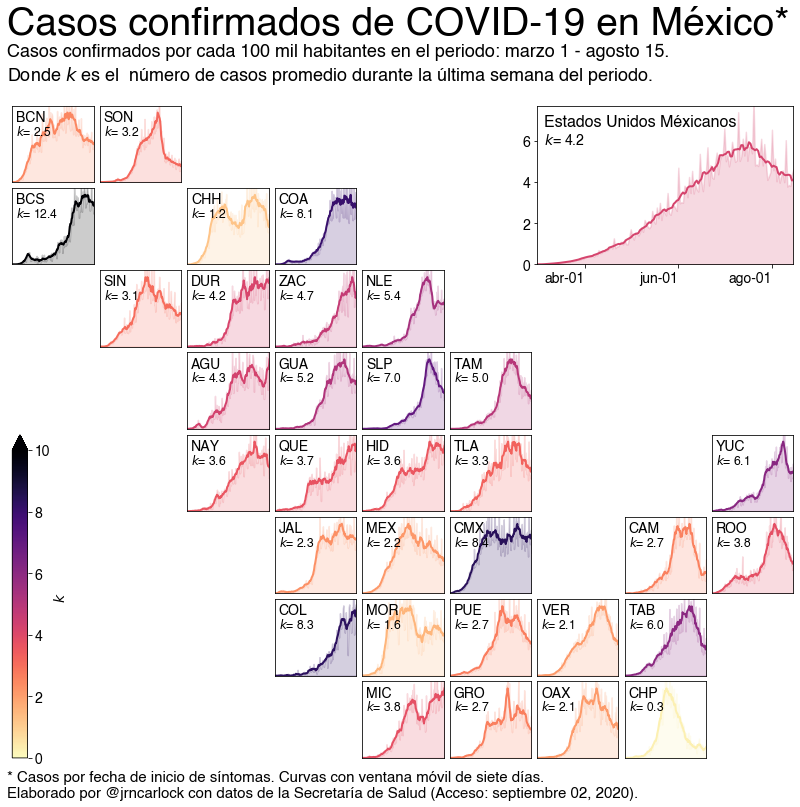

In [29]:
fig1 = plt.figure(figsize=(14,12))
G = gridspec.GridSpec(ncols=9, nrows=8, figure=fig1, wspace=0.075, hspace=0.075)

ax01 = fig1.add_subplot(G[0, 0])
ax02 = fig1.add_subplot(G[0, 1])
ax03 = fig1.add_subplot(G[1, 0])
ax04 = fig1.add_subplot(G[1, 2])
ax05 = fig1.add_subplot(G[1, 3])
ax06 = fig1.add_subplot(G[2, 1])
ax07 = fig1.add_subplot(G[2, 2])
ax08 = fig1.add_subplot(G[2, 3])
ax09 = fig1.add_subplot(G[2, 4])
ax10 = fig1.add_subplot(G[3, 2])
ax11 = fig1.add_subplot(G[3, 3])
ax12 = fig1.add_subplot(G[3, 4])
ax13 = fig1.add_subplot(G[3, 5])
ax14 = fig1.add_subplot(G[4, 2])
ax15 = fig1.add_subplot(G[4, 3])
ax16 = fig1.add_subplot(G[4, 4])
ax17 = fig1.add_subplot(G[4, 5])
ax18 = fig1.add_subplot(G[4, 8])
ax19 = fig1.add_subplot(G[5, 3])
ax20 = fig1.add_subplot(G[5, 4])
ax21 = fig1.add_subplot(G[5, 5])
ax22 = fig1.add_subplot(G[5, 7])
ax23 = fig1.add_subplot(G[5, 8])
ax24 = fig1.add_subplot(G[6, 3])
ax25 = fig1.add_subplot(G[6, 4])
ax26 = fig1.add_subplot(G[6, 5])
ax27 = fig1.add_subplot(G[6, 6])
ax28 = fig1.add_subplot(G[6, 7])
ax29 = fig1.add_subplot(G[7, 4])
ax30 = fig1.add_subplot(G[7, 5])
ax31 = fig1.add_subplot(G[7, 6])
ax32 = fig1.add_subplot(G[7, 7])
ax33 = fig1.add_subplot(G[0:2, 6:])
ax34 = fig1.add_subplot(G[4:, :2])

axes = [ax01, ax02, 
        ax03, ax04, ax05, 
        ax06, ax07, ax08, ax09, 
        ax10, ax11, ax12, ax13, 
        ax14, ax15, ax16, ax17, ax18, 
        ax19, ax20, ax21, ax22, ax23, 
        ax24, ax25, ax26, ax27, ax28, 
        ax29, ax30,ax31, ax32, 
        ax33, ax34]

entidades = ["BAJA CALIFORNIA", "SONORA", 
             "BCS", "CHIHUAHUA", "COAHUILA", 
             "SINALOA", "DURANGO", "ZACATECAS", "NUEVO LEÓN", 
             "AGUASCALIENTES", "GUANAJUATO", "SAN LUIS POTOSÍ", "TAMAULIPAS", 
             "NAYARIT", "QUERÉTARO", "HIDALGO", "TLAXCALA", "YUCATÁN", 
             "JALISCO", "MÉXICO", "CDMX", "CAMPECHE", "QUINTANA ROO", 
             "COLIMA", "MORELOS", "PUEBLA", "VERACRUZ", "TABASCO", 
             "MICHOACÁN", "GUERRERO", "OAXACA", "CHIAPAS"]

state_label = codify(entidades)


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
for k in range(len(entidades)):
    
    axes[k].set_xticks([])
    axes[k].set_yticks([])
        
    my_data = data_relative
    state_name = entidades[k]
    state = my_data[state_name]-my_data[state_name].shift(1)
    average = state.rolling(window=7, min_periods=1, center=True).mean()
    days = 7
    peak = average.max()
    avg = average[-days:].mean()

    if avg > 0.5*peak: color='red'
    elif avg < 0.2*peak and avg < 0.2: color='green'
    else: color='orange'
    
    norm = plt.Normalize(vmin=0, vmax=10)
    cmap = cm.magma_r
    color = avg/10

    axes[k].fill_between(state.index, 0, state, linewidth=1.5, color=cmap(color), zorder=1, alpha=0.2)
    axes[k].plot(average, linewidth=2, color=cmap(color), zorder=1)

    axes[k].set_xlim(pd.to_datetime('2020-03-01'),pd.to_datetime('2020-08-15'))
    axes[k].set_ylim(0,peak*1.10)

    axes[k].text(0.05,0.80, state_label['codes'][k], 
                 fontsize=14, transform=axes[k].transAxes, ha='left')
    
    axes[k].text(0.05,0.62, '$k$= '+str(round(avg,1)), 
        fontsize=12, transform=axes[k].transAxes, ha='left', color='k')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
k = 32

my_data = data_relative.mean(axis=1)
state = my_data-my_data.shift(1)
average = state.rolling(window=7, min_periods=1, center=True).mean()
days = 7
peak = average.max()
avg = average[-days:].mean()

if avg > 0.5*peak: color='red'
elif avg < 0.2*peak and avg < 0.1: color='green'
else: color='orange'
    
cmap = cm.magma_r
color = avg/10

axes[k].fill_between(state.index, 0, state, linewidth=1.5, color=cmap(color), zorder=1, alpha=0.2)
axes[k].plot(average, linewidth=2, color=cmap(color), zorder=2)

axes[k].set_xlim(pd.to_datetime('2020-03-01'),pd.to_datetime('2020-08-15'))
mi_formato = mdates.DateFormatter("%b-%d")
axes[k].xaxis.set_major_formatter(mi_formato)
axes[k].xaxis.set_major_locator(plt.MaxNLocator(4))
my_dates=pd.to_datetime(['2020-04-01','2020-06-01','2020-08-01'])
axes[k].set_xticks(my_dates)
axes[k].tick_params(axis='x', labelsize=14)
plt.setp(axes[k].get_xticklabels(), rotation=0, ha="right")

axes[k].set_ylim(0,peak*1.30)
axes[k].yaxis.set_major_locator(plt.MaxNLocator(5))
axes[k].tick_params(axis='y', labelsize=14)

axes[k].text(0.025,0.87, "Estados Unidos Méxicanos", 
             fontsize=16, transform=axes[k].transAxes, ha='left')

axes[k].text(0.025,0.76, '$k$= '+str(round(avg,1)), 
             fontsize=14, transform=axes[k].transAxes, ha='left', color='k')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
k = 33

axes[k].set_xticks([])
axes[k].set_yticks([])
axes[k].spines['right'].set_visible(False)
axes[k].spines['left'].set_visible(False)
axes[k].spines['top'].set_visible(False)
axes[k].spines['bottom'].set_visible(False)

divider = make_axes_locatable(axes[k])
cax = divider.append_axes("left", size="10%", pad=0)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes[k], cax=cax, extend='max', aspect=40)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("$k$", rotation=90, size=14, labelpad=3)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

fig1.suptitle('Casos confirmados de COVID-19 en México*', 
             fontsize=39, weight= 'bold', ha='left', x= 0.12, y= 0.995)

fig1.text(0.12,0.910,
         "Casos confirmados por cada 100 mil habitantes en el periodo: marzo 1 - agosto 15."+
         "\nDonde $k$ es el  número de casos promedio durante la última semana del periodo.", 
         fontsize=18, ha='left', color='k')

fig1.text(0.12,0.08,  
         "* Casos por fecha de inicio de síntomas. Curvas con ventana móvil de siete días." + 
         "\nElaborado por @jrncarlock con datos de la Secretaría de Salud (Acceso: "+ date +").",
         fontsize=15, ha='left', color='k')

#fig1.tight_layout()

In [30]:
fig1.savefig('./images/profiles_mapa.png',dpi=300, bbox_inches='tight')